In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from IPython.display import display
from datetime import datetime, timedelta

# Function to calculate historical volatility (HV)
def calculate_hv(stock_data, window=30):
    returns = stock_data['Close'].pct_change().dropna()
    hv = np.std(returns) * np.sqrt(252)  # Annualized HV
    return hv

# Function to find the optimal straddle strategy
def find_optimal_straddle(ticker, hv_window=30):
    try:
        stock = yf.Ticker(ticker)
        stock_data = stock.history(period="6mo", interval="1d")

        if stock_data.empty:
            print(f"No historical data found for {ticker}.")
            return None

        # Calculate Historical Volatility (HV)
        hv = calculate_hv(stock_data, window=hv_window)

        # Get current stock price
        current_price = stock_data['Close'].iloc[-1]

        # Fetch all options data
        expiration_dates = stock.options
        if not expiration_dates:
            print(f"No options data available for {ticker}.")
            return None

        optimal_results = []

        for expiry in expiration_dates:
            options_chain = stock.option_chain(date=expiry)
            calls = options_chain.calls
            puts = options_chain.puts

            # Find ATM options
            calls['distance_to_atm'] = abs(calls['strike'] - current_price)
            puts['distance_to_atm'] = abs(puts['strike'] - current_price)

            atm_call = calls.loc[calls['distance_to_atm'].idxmin()]
            atm_put = puts.loc[puts['distance_to_atm'].idxmin()]

            # Calculate metrics
            avg_iv = (atm_call.get("impliedVolatility", 0) + atm_put.get("impliedVolatility", 0)) / 2
            total_premium = atm_call['lastPrice'] + atm_put['lastPrice']

            # Store results for each expiration date
            optimal_results.append({
                "Ticker": ticker,
                "Expiration": expiry,
                "ATM Strike": atm_call["strike"],
                "Average IV": avg_iv,
                "HV": hv,
                "IV-HV Difference": avg_iv - hv,
                "Total Premium": total_premium
            })

        # Return the results for the stock
        return pd.DataFrame(optimal_results)

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return None

# Function to filter the results
def filter_straddle_data(df):
    # Set thresholds
    min_premium = 5.0
    max_iv = 0.35
    max_iv_hv_diff = 0.05

    # Calculate dynamic max expiration date (1 year from today)
    max_expiration_date = (datetime.today() + timedelta(days=365)).strftime("%Y-%m-%d")

    # Apply filters and create a copy
    filtered_df = df[
        (df["Total Premium"] >= min_premium) & 
        (df["Average IV"] <= max_iv) & 
        (abs(df["IV-HV Difference"]) <= max_iv_hv_diff) & 
        (df["Expiration"] <= max_expiration_date)
    ].copy()

    # Add Premium-to-IV Ratio
    filtered_df["Premium-to-IV Ratio"] = filtered_df["Total Premium"] / filtered_df["Average IV"]
    
    return filtered_df.sort_values(by="Premium-to-IV Ratio", ascending=False)

# Main execution
if __name__ == "__main__":
    # Load tickers from CSV
    file_path = r'C:\Users\allis\Downloads\portfolio_pick (1).csv'
    tickers_data = pd.read_csv(file_path)
    ticker_list = tickers_data["Stock"].tolist()

    all_results = []

    for ticker in ticker_list:
        print(f"Processing {ticker}...")
        result = find_optimal_straddle(ticker)
        if result is not None:
            all_results.append(result)

    # Combine results for all stocks
    if all_results:
        final_df = pd.concat(all_results).sort_values(by=["Ticker", "IV-HV Difference"])
        print("Filtering results...")
        filtered_results = filter_straddle_data(final_df)
        display(filtered_results)

        # Save filtered results to a CSV
        filtered_results.to_csv("filtered_straddle_results.csv", index=False)
        print("Filtered results saved to 'filtered_straddle_results.csv'.")
    else:
        print("No results to display.")

Processing EBAY...
Processing CMG...
Processing EXPE...
Processing F...
Processing GM...
Processing HD...
Error processing HD: attempt to get argmin of an empty sequence
Processing MAR...
Processing PG...
Processing DG...
Processing XOM...
Error processing XOM: attempt to get argmin of an empty sequence
Processing AXP...
Processing BAC...
Processing BLK...
Processing FIS...
Error processing FIS: attempt to get argmin of an empty sequence
Processing GS...
Processing MS...
Processing USB...
Processing WFC...
Processing BDX...
Processing BIIB...
Error processing BIIB: attempt to get argmin of an empty sequence
Processing ELV...
Processing PFE...
Processing LMT...
Processing AMT...
Processing ACN...
Processing ADI...
Processing AMD...
Processing CRM...
Processing MU...
Processing NXPI...
Processing QCOM...
Filtering results...


,Ticker,Expiration,ATM Strike,Average IV,HV,IV-HV Difference,Total Premium,Premium-to-IV Ratio
13,GS,2025-12-19,570.0,0.273719,0.309658,-0.035939,125.28,457.694962
12,GS,2025-09-19,570.0,0.280490,0.309658,-0.029168,100.05,356.696648
10,GS,2025-07-18,570.0,0.277122,0.309658,-0.032536,93.80,338.478963
9,GS,2025-06-20,570.0,0.279472,0.309658,-0.030186,90.65,324.361738
11,GS,2025-08-15,570.0,0.277305,0.309658,-0.032353,86.65,312.471601
...,...,...,...,...,...,...,...,...
11,USB,2025-09-19,47.5,0.312690,0.270055,0.042635,6.85,21.906682
6,WFC,2025-02-21,70.0,0.329413,0.350894,-0.021480,6.97,21.158821
9,USB,2025-06-20,47.5,0.306281,0.270055,0.036226,5.63,18.381792
0,ADI,2024-12-27,212.5,0.330695,0.337642,-0.006947,5.77,17.448093


Filtered results saved to 'filtered_straddle_results.csv'.


In [21]:
# Select the best strategy for each stock
best_strategies = filtered_results.sort_values(
    by=["Ticker", "Premium-to-IV Ratio", "IV-HV Difference"],
    ascending=[True, False, True]
).groupby("Ticker").first().reset_index()

# Save the results to a CSV file
best_strategies.to_csv("best_straddle_strategies.csv", index=False)

# Display the results
best_strategies

,Ticker,Expiration,ATM Strike,Average IV,HV,IV-HV Difference,Total Premium,Premium-to-IV Ratio
0,ACN,2025-09-19,370.0,0.250259,0.237255,0.013004,59.10,236.155091
1,ADI,2025-09-19,210.0,0.322456,0.337642,-0.015187,49.50,153.509551
2,AMT,2025-09-19,185.0,0.293632,0.263823,0.029809,48.90,166.535016
3,AXP,2025-09-19,300.0,0.282753,0.265608,0.017145,57.71,204.100735
4,BAC,2025-09-19,45.0,0.255256,0.249612,0.005644,7.95,31.145146
5,BDX,2025-06-20,230.0,0.232384,0.184163,0.048221,24.35,104.783563
6,CMG,2025-06-20,62.0,0.345710,0.341332,0.004378,11.80,34.132687
7,CRM,2025-02-21,340.0,0.297523,0.313209,-0.015686,31.95,107.386694
8,EXPE,2025-01-31,185.0,0.341010,0.339378,0.001632,14.17,41.553033
9,GM,2025-09-19,52.5,0.343390,0.364076,-0.020686,12.05,35.091259


In [23]:
def filter_straddle_strategies(df):
    # Apply filtering conditions
    df = df[
        (df["Average IV"] <= 0.30) | (df["Premium-to-IV Ratio"] > 200)  # IV limit or exceptional ratio
    ]
    df = df[
        (df["Premium-to-IV Ratio"] >= 50) & (df["Total Premium"] >= 20)  # Adequate premium and ratio
    ]
    df = df[
        (abs(df["IV-HV Difference"]) <= 0.05)  # IV-HV difference close to zero
    ]
    
    # Select one optimal strategy per stock
    best_strategies = df.sort_values(
        by=["Ticker", "Premium-to-IV Ratio", "IV-HV Difference"],
        ascending=[True, False, True]
    ).groupby("Ticker").first().reset_index()
    
    return best_strategies

print(best_strategies)


   Ticker  Expiration  ATM Strike  Average IV        HV  IV-HV Difference  \
0     ACN  2025-09-19       370.0    0.250259  0.237255          0.013004   
1     ADI  2025-09-19       210.0    0.322456  0.337642         -0.015187   
2     AMT  2025-09-19       185.0    0.293632  0.263823          0.029809   
3     AXP  2025-09-19       300.0    0.282753  0.265608          0.017145   
4     BAC  2025-09-19        45.0    0.255256  0.249612          0.005644   
5     BDX  2025-06-20       230.0    0.232384  0.184163          0.048221   
6     CMG  2025-06-20        62.0    0.345710  0.341332          0.004378   
7     CRM  2025-02-21       340.0    0.297523  0.313209         -0.015686   
8    EXPE  2025-01-31       185.0    0.341010  0.339378          0.001632   
9      GM  2025-09-19        52.5    0.343390  0.364076         -0.020686   
10     GS  2025-12-19       570.0    0.273719  0.309658         -0.035939   
11    LMT  2025-09-19       490.0    0.236801  0.196983          0.039818   

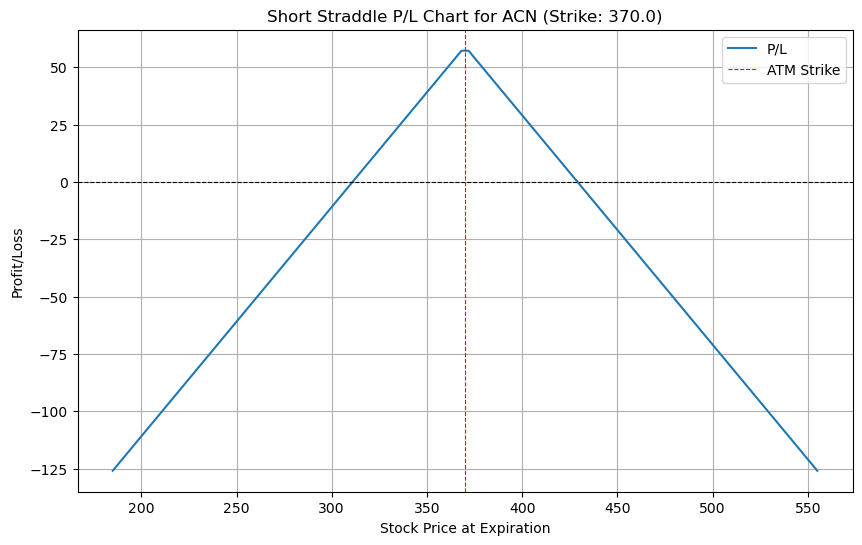

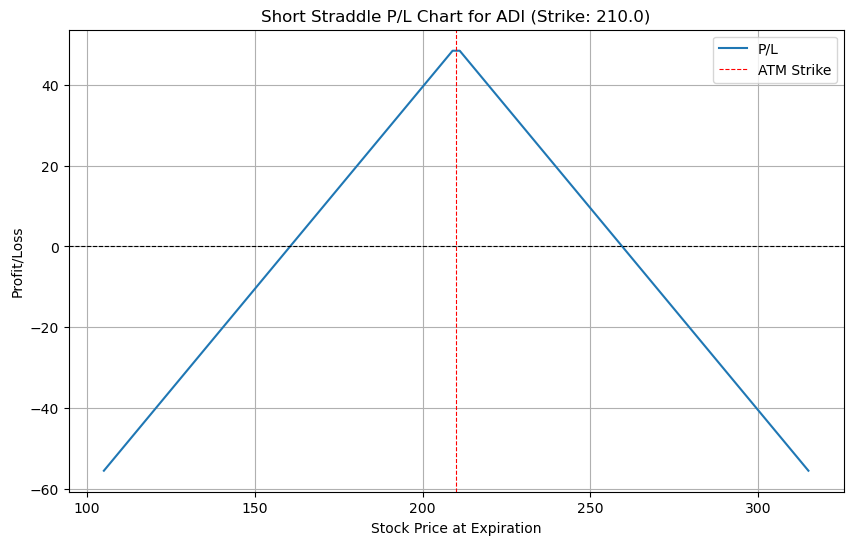

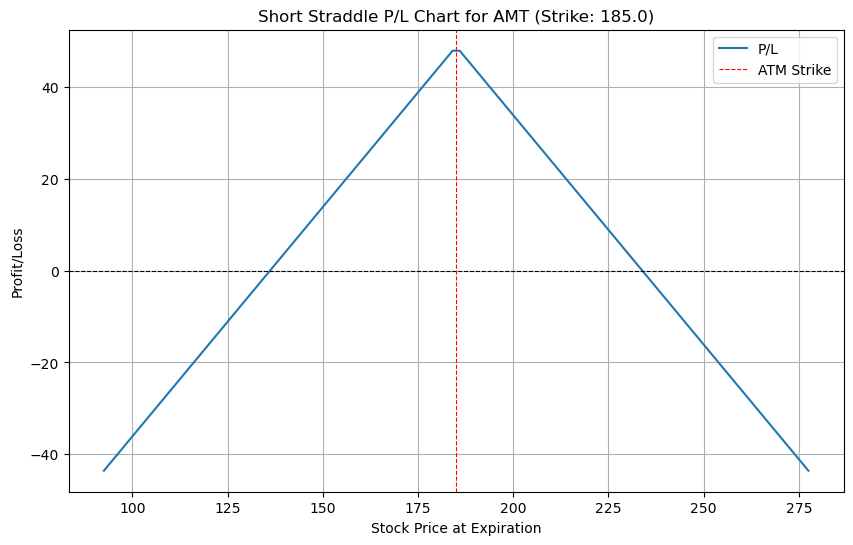

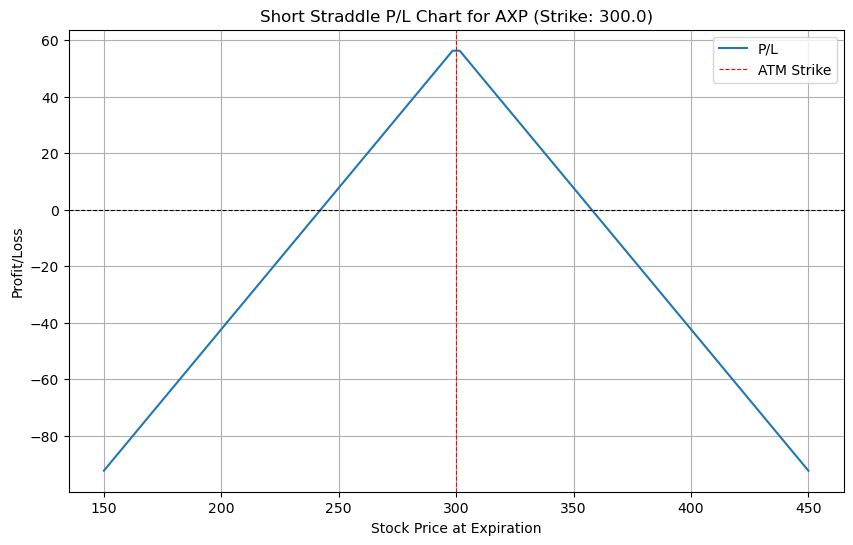

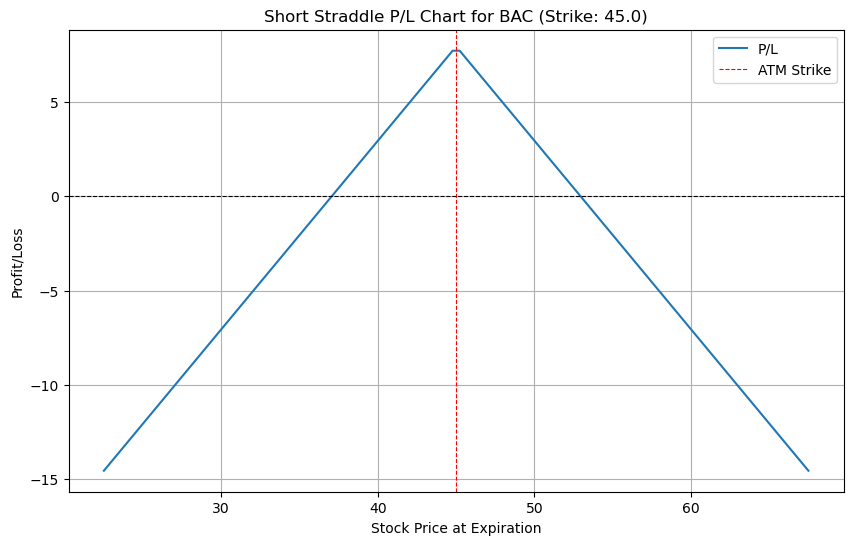

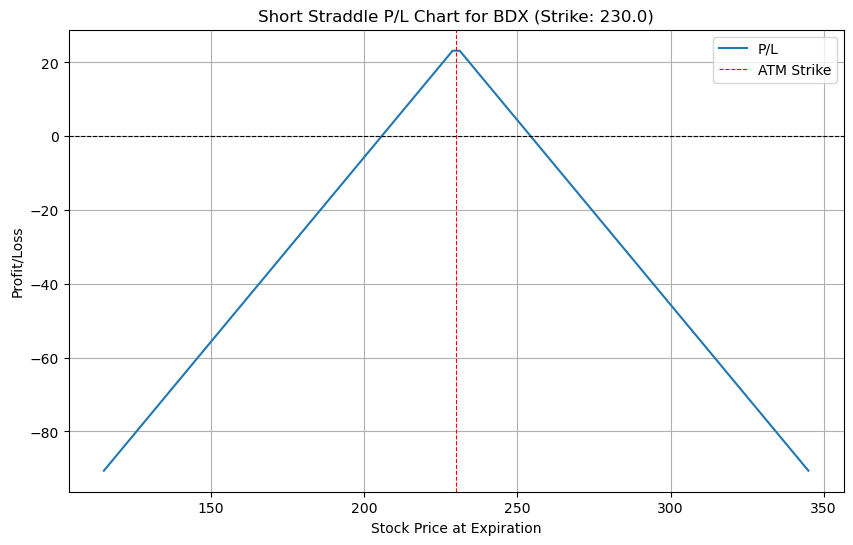

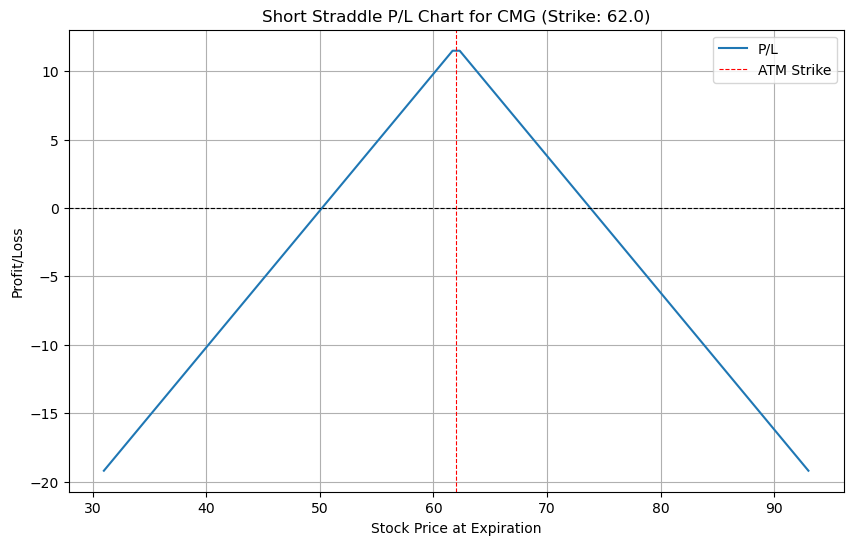

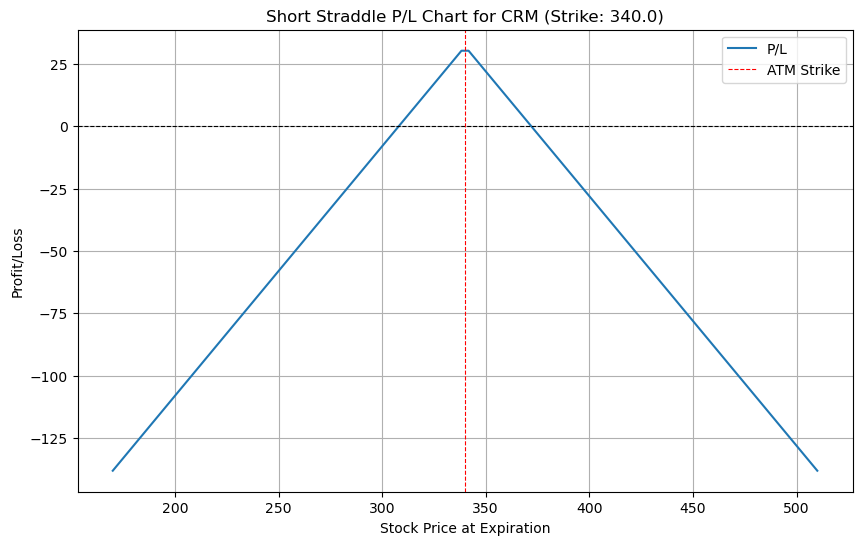

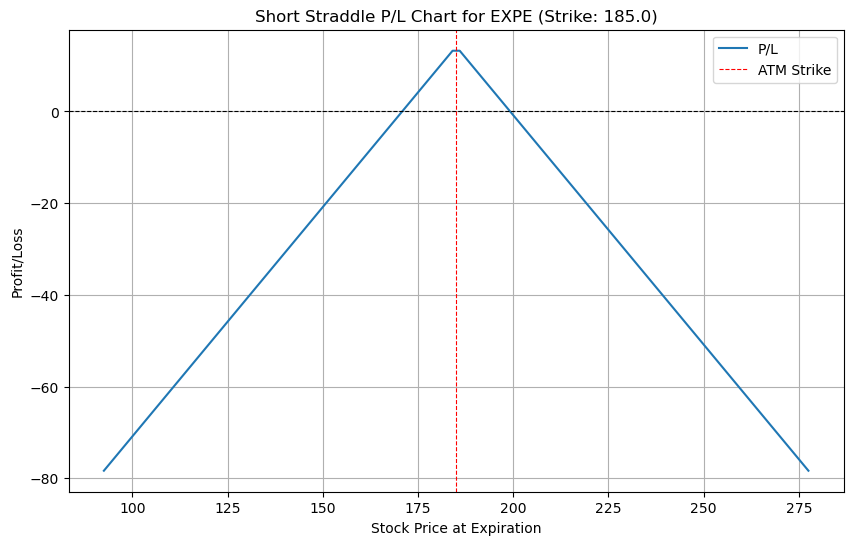

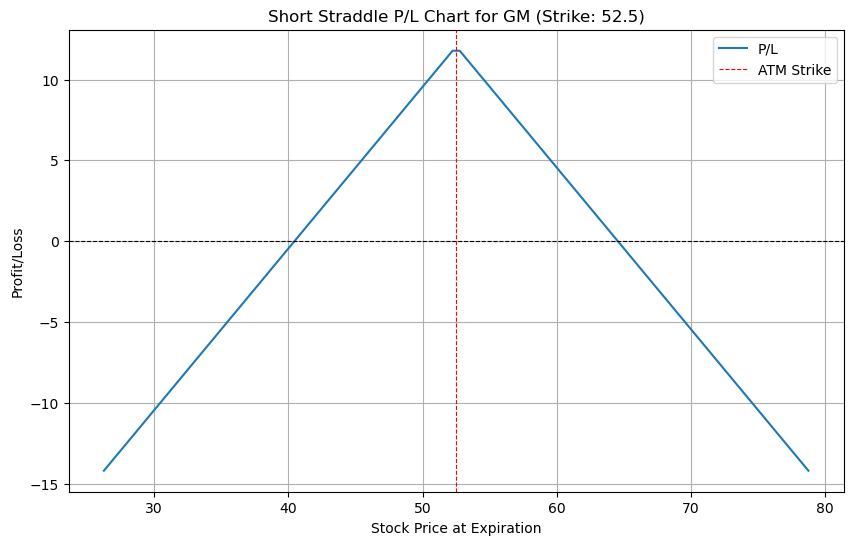

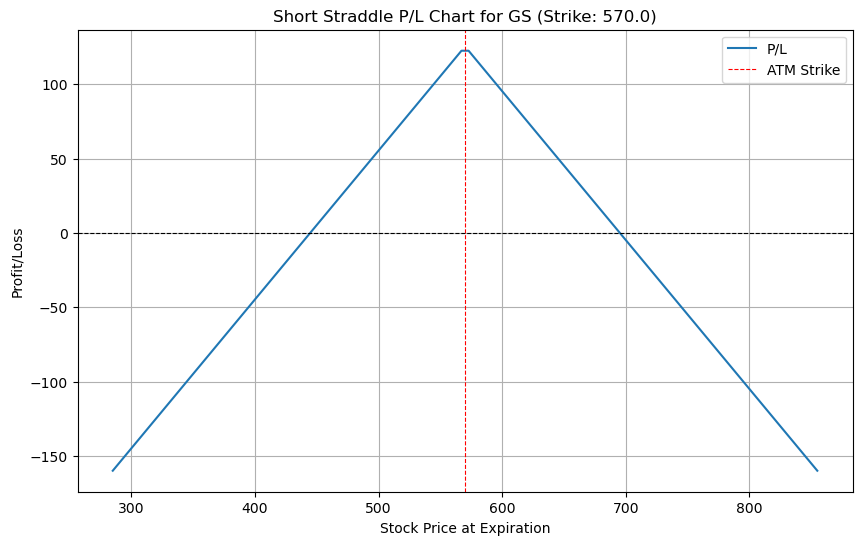

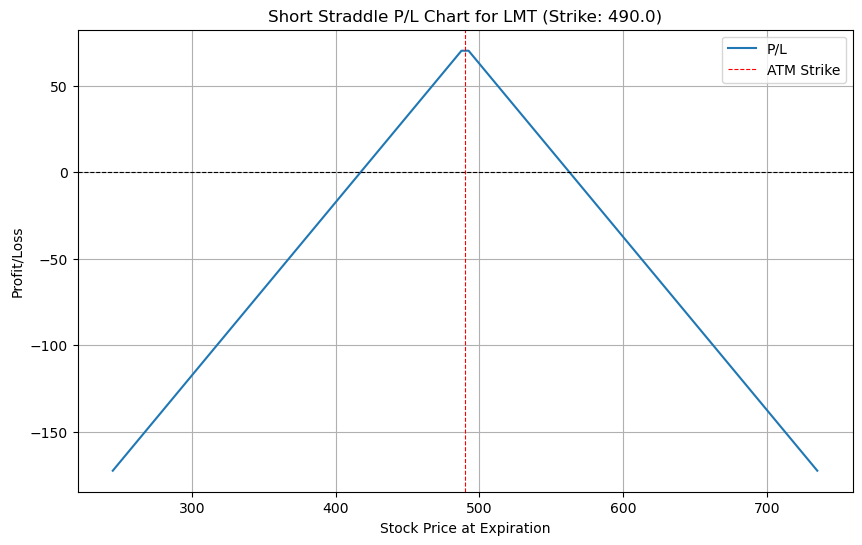

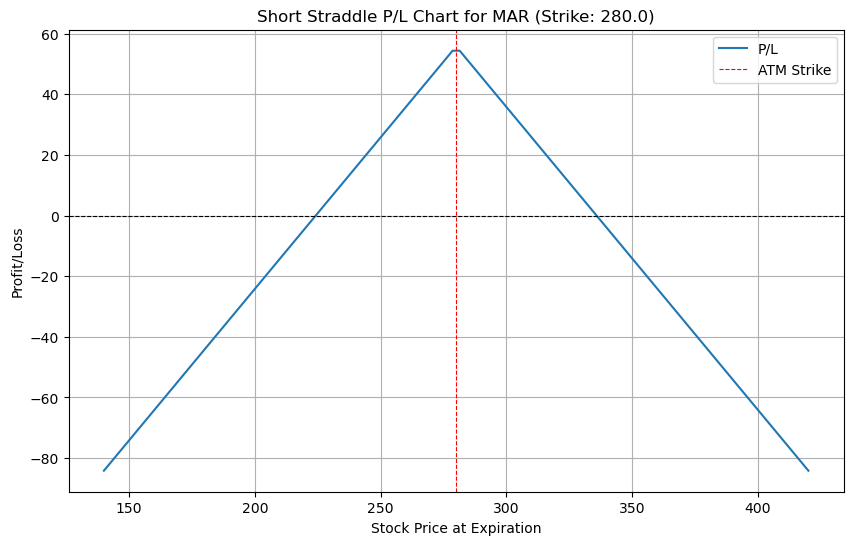

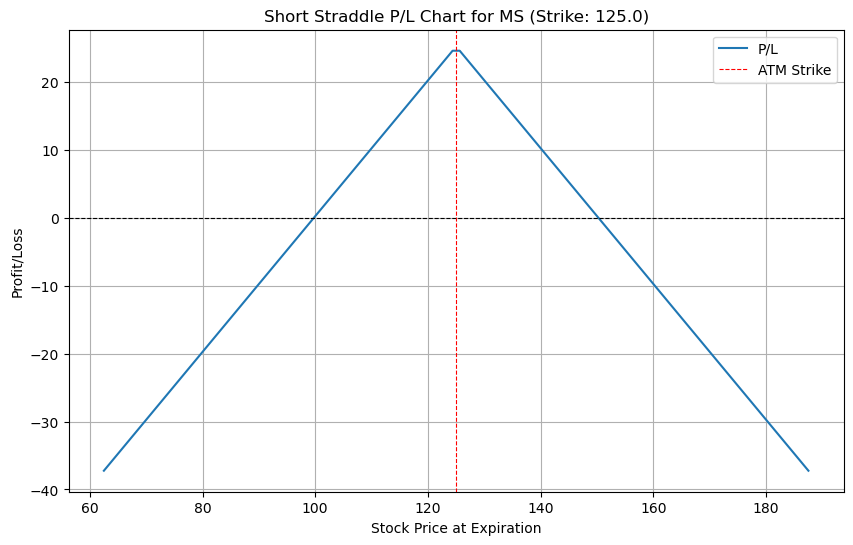

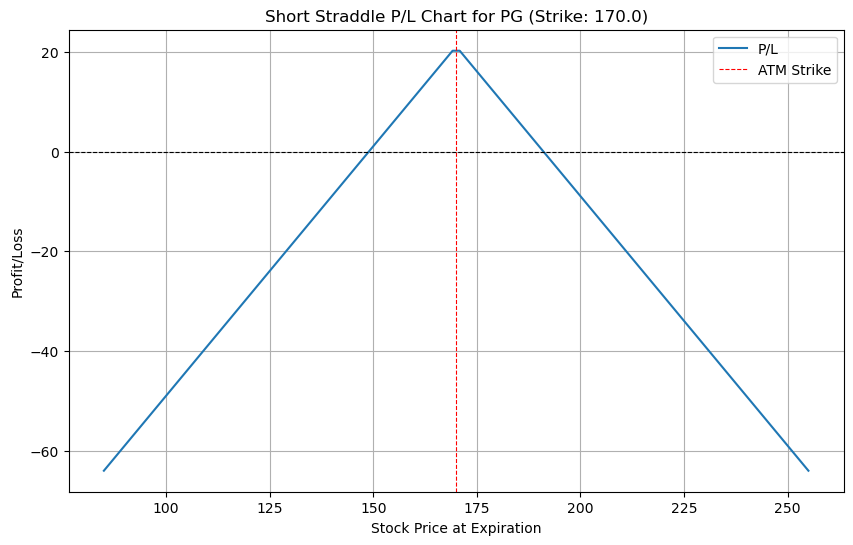

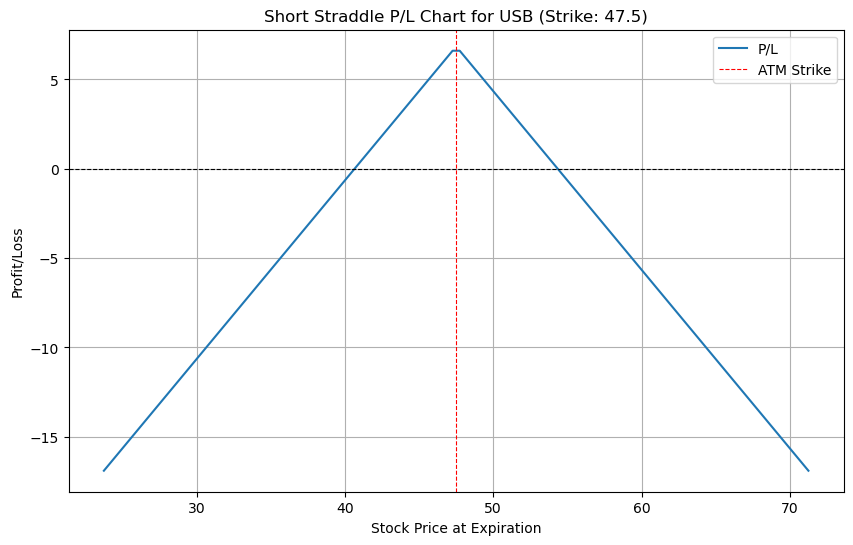

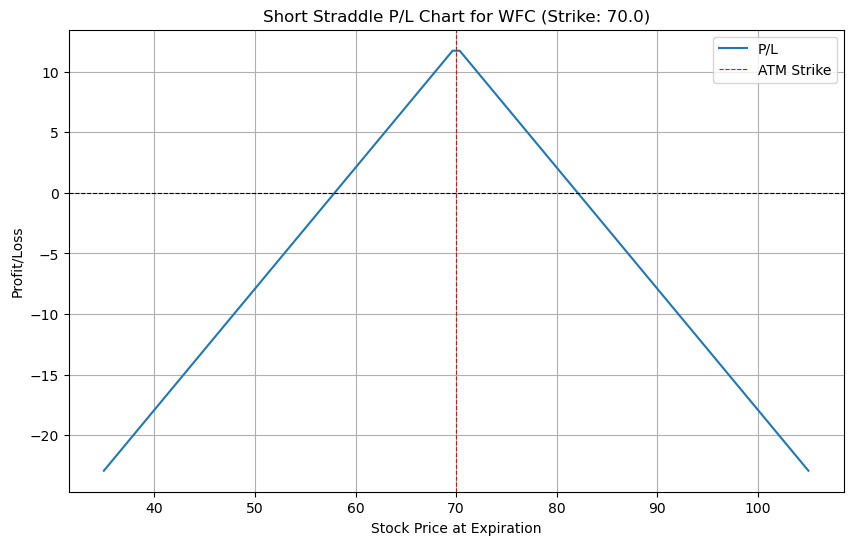

In [25]:
import matplotlib.pyplot as plt
def plot_straddle_pl(ticker, atm_strike, total_premium):
    # Define the range of stock prices
    price_range = np.linspace(atm_strike * 0.5, atm_strike * 1.5, 100)  # From 50% to 150% of ATM strike

    # Calculate P/L for a short straddle
    pl = total_premium - np.maximum(0, price_range - atm_strike) - np.maximum(0, atm_strike - price_range)

    # Plot the P/L chart
    plt.figure(figsize=(10, 6))
    plt.plot(price_range, pl, label="P/L")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Break-even line
    plt.axvline(atm_strike, color="red", linestyle="--", linewidth=0.8, label="ATM Strike")  # ATM strike price
    plt.title(f"Short Straddle P/L Chart for {ticker} (Strike: {atm_strike})")
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Profit/Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate P/L charts for all selected strategies
for _, row in best_strategies.iterrows():
    plot_straddle_pl(row["Ticker"], row["ATM Strike"], row["Total Premium"])